# Introduction

This notebook is dedicated to calculating and predicting the closing price of Brent Crude Oil using the "Close" column as the target variable (or 'y'). The primary goal is to build and evaluate models that can accurately predict the closing price based on various features within the dataset.

To achieve this, we will use a deep learning framework, specifically a Long Short-Term Memory (LSTM) network, which is well-suited for capturing temporal dependencies in the data. We will explore both univariate and multivariate approaches to understand the effectiveness of each method.

The multivariate model leverages multiple features to predict the closing price of Brent Crude Oil. By using various features such as "Open", "High", "Low", "Volume", and "Close", we aim to capture more complex relationships and dependencies within the data, which can lead to more accurate predictions. The workflow for the multivariate model will follow these detailed steps:
- **Load Data:** Import the dataset and perform initial data inspection to understand its structure and contents.
- **Data Preprocessing:** Clean the data by handling missing values, encoding categorical variables if necessary, and normalizing numerical features.
- **Feature Selection:** Use all available features ("Close", "Open", "High", "Low", "Volume") in the dataset for model training.
- **Train-Test Split:** Divide the dataset into training and testing sets to evaluate model performance.
- **Model Training:** Train the LSTM model using the training data with multiple features.
- **Model Evaluation:** Assess the performance of the trained model using various metrics.
- **Model 1 and 2:** Optimize model perparameters to improve accuracy and other performance metrics.
- **Final Evaluation:** Conduct a final evaluation of the tuned model on the test data.
- **Best Model Selection**
- **Comparison:** Compare the performance of the univariate and multivariate models.
- **Selection:** Select the best model based on evaluation metrics.

For evaluating the performance of the model, the following metrics will be used:
- **Mean Absolute Error (MAE):** The average of the absolute differences between the predicted and actual values.
- **Mean Squared Error (MSE):** The average of the squared differences between the predicted and actual values.
- **R-squared (R²):** A statistical measure that represents the proportion of the variance for the target variable explained by the features.
- **Root Mean Squared Error (RMSE):** The square root of the average of the squared differences between the predicted and actual values.

By following these steps, we aim to develop a robust model that can accurately predict Brent Oil Prices.

In [1]:
#!nvcc -V && which nvcc

In [2]:
#!python --version
#!nvidia-smi

In [3]:
# !pip install cudf-cu12 --extra-index-url=https://pypi.nvidia.com

# Importing Libraries

In [4]:
# importing libraries fundamentals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy as sp
import warnings
import datetime
from matplotlib import pyplot

# Library for Null Values Imputing
import missingno as msno
from sklearn.impute import KNNImputer

# Library for Encoding and Imputer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

# Library for Deep Learning Frameworks
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.layers import *

# importing cudas

2024-07-27 11:47:44.262036: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-27 11:47:44.262142: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-27 11:47:44.361899: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading the Dataset

In [5]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/all_fuels_data.csv
/kaggle/input/individual_data/RBOB_Gasoline_data.csv
/kaggle/input/individual_data/Heating_Oil_data.csv
/kaggle/input/individual_data/Brent_Crude_Oil_data.csv
/kaggle/input/individual_data/Crude_Oil_data.csv
/kaggle/input/individual_data/Natural_Gas_data.csv


In [6]:
# load cudas extension

# %load_ext cudf.pandas

df = pd.read_csv('/kaggle/input/individual_data/Brent_Crude_Oil_data.csv')

## Dataset Information

In [7]:
df.head(5)

,date,open,high,low,close,volume
0,2007-07-30,75.849998,76.529999,75.440002,75.739998,2575
1,2007-07-31,75.699997,77.169998,75.669998,77.050003,3513
2,2007-08-01,77.000000,77.059998,74.860001,75.349998,3930
3,2007-08-02,75.220001,76.209999,74.269997,75.760002,6180
4,2007-08-03,75.389999,76.000000,74.529999,74.750000,4387


In [8]:
print(df.shape)

(4196, 6)


In [9]:
df.describe()

,open,high,low,close,volume
count,4196.000000,4196.000000,4196.000000,4196.000000,4196.000000
mean,78.714840,79.678634,77.697379,78.718501,17575.080076
std,24.679305,24.797561,24.549678,24.697751,16192.218784
min,19.559999,21.270000,16.000000,19.330000,0.000000
25%,59.190001,60.232501,58.342499,59.250000,1139.500000
50%,76.869999,77.785000,75.805000,77.045002,16783.000000
75%,101.632498,102.820000,100.290001,101.609999,30150.500000
max,146.080002,147.429993,144.270004,146.080002,87185.000000


In [10]:
df.describe(include='object').T

,count,unique,top,freq
date,4196,4196,2024-06-24,1


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4196 entries, 0 to 4195
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    4196 non-null   object 
 1   open    4196 non-null   float64
 2   high    4196 non-null   float64
 3   low     4196 non-null   float64
 4   close   4196 non-null   float64
 5   volume  4196 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 196.8+ KB


In [12]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns
print(cat_cols)

Index(['date'], dtype='object')


In [13]:
num_cols = df.select_dtypes(include=['float', 'int64']).columns
print(num_cols)

Index(['open', 'high', 'low', 'close', 'volume'], dtype='object')


## Dealt with Null Values



In [14]:
df.isnull().sum(),

(date      0
 open      0
 high      0
 low       0
 close     0
 volume    0
 dtype: int64,)

In [15]:
missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
df[missing_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4196 entries, 0 to 4195
Empty DataFrame


# Feature Engineering & Indexing Datetime

In [16]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4196 entries, 2007-07-30 to 2024-06-24
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    4196 non-null   float64
 1   high    4196 non-null   float64
 2   low     4196 non-null   float64
 3   close   4196 non-null   float64
 4   volume  4196 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 196.7 KB


In [17]:
df.head()

,open,high,low,close,volume
date,,,,,
2007-07-30,75.849998,76.529999,75.440002,75.739998,2575
2007-07-31,75.699997,77.169998,75.669998,77.050003,3513
2007-08-01,77.000000,77.059998,74.860001,75.349998,3930
2007-08-02,75.220001,76.209999,74.269997,75.760002,6180
2007-08-03,75.389999,76.000000,74.529999,74.750000,4387


# Scalling Data (Only Num Cols)

In [18]:
list_num_cols = [ 'open', 'high', 'low', 'volume' ]

In [19]:
scaler = StandardScaler()
df[list_num_cols] = scaler.fit_transform(df[list_num_cols])

# Splitting Data & Sequencing Data

In [20]:
window_size = 5

def create_multivariate_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data.iloc[i:i + window_size].values)
        y.append(data.iloc[i + window_size]['close'])  # Adjust if predicting a different column
    return np.array(X), np.array(y)

In [21]:
X, y = create_multivariate_sequences(df, window_size)
X.shape, y.shape

((4191, 5, 5), (4191,))

In [22]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape 

((2933, 5, 5), (2933,), (629, 5, 5), (629,), (629, 5, 5), (629,))

# Long Short Term Memory (LSTM)

## Build Model 1

In [23]:
# Build simple model for LSTM
def build_model_lstm1():
    model = Sequential()
    model.add(InputLayer((5, 5))) # input layer with was timesteps, features
    model.add(LSTM(64))
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))
    return model

model1 = build_model_lstm1()
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# make checkpoint for each models has been compile

cp1 = ModelCheckpoint('model1.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [25]:
# Train the model
history1 = model1.fit(X_train, y_train, 
                        validation_split=0.3, 
                        epochs=150, 
                        batch_size=32, 
                        callbacks=[cp1]
                     )

Epoch 1/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 8904.2822 - root_mean_squared_error: 94.3614 - val_loss: 3486.1299 - val_root_mean_squared_error: 59.0435
Epoch 2/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8688.2139 - root_mean_squared_error: 93.2056 - val_loss: 3436.5151 - val_root_mean_squared_error: 58.6218
Epoch 3/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8612.2910 - root_mean_squared_error: 92.8009 - val_loss: 3376.5510 - val_root_mean_squared_error: 58.1081
Epoch 4/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8606.3965 - root_mean_squared_error: 92.7659 - val_loss: 3302.1313 - val_root_mean_squared_error: 57.4642
Epoch 5/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8361.3301 - root_mean_squared_error: 91.4369 - val_loss: 3182.4292 - val_root_mean_squared_error: 56.4130
Epoch 6/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8269.4590 - root_mean_squared_error: 90.9322 - val_loss: 2920.5691 - val_root_mean_squared_error: 54.0423
Epoch 7/1

In [26]:
from tensorflow.keras.models import load_model
model_pred1 = load_model('model1.keras')

In [27]:
print(y_train[:5])

[71.16999817 71.80000305 70.98999786 70.20999908 70.38999939]


In [28]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,Train Predictions,Actuals
0,74.834984,71.169998
1,71.738342,71.800003
2,71.780457,70.989998
3,71.183060,70.209999
4,70.241577,70.389999
...,...,...
2928,61.483746,62.009998
2929,61.492500,60.939999
2930,60.719440,62.139999
2931,61.561508,61.820000


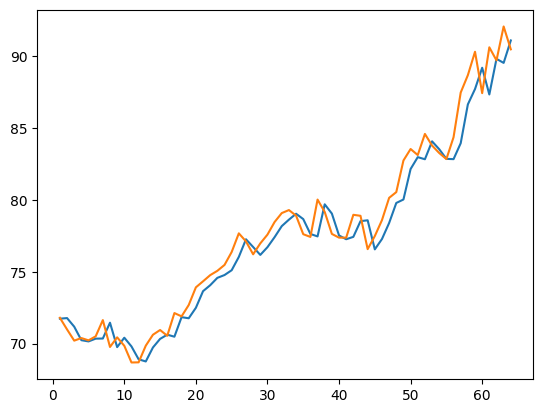

In [29]:
plt.plot(train_results['Train Predictions'][1:65])
plt.plot(train_results['Actuals'][1:65])

In [30]:
# Metrics Performance 

y_pred1 = model1.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, y_pred1)}')
print(f'MSE: {mean_squared_error(y_test, y_pred1)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred1))}')
print(f'R²: {r2_score(y_test, y_pred1)}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
MAE: 1.9935336211527477
MSE: 8.001166198464462
RMSE: 2.8286332739442317
R²: 0.9409316326064295


## Build Model 2

In [31]:
def build_model_lstm2():
    model = Sequential()
    model.add(InputLayer((5, 5))) # input layer for window size and train size (features dimensions)
    model.add(Conv1D(128, kernel_size=2, activation='relu'))
    model.add(Flatten())
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))
    model.summary()
    return model

model2 = build_model_lstm2()
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 4, 128)         │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         4,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,521 (21.57 KB)

 Trainable params: 5,521 (21.57 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 4, 128)         │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         4,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,521 (21.57 KB)

 Trainable params: 5,521 (21.57 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# make checkpoint for each models has been compile

cp2 = ModelCheckpoint('model2.keras', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [33]:
# Train the model

history2 = model2.fit(X_train, y_train, 
                    validation_split=0.3, 
                    epochs=150, 
                    batch_size=32, 
                    callbacks=[cp2])

Epoch 1/150
63/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6094.4990 - root_mean_squared_error: 77.5751

I0000 00:00:1722080936.527652     143 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722080936.546525     143 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6032.8413 - root_mean_squared_error: 77.1561

W0000 00:00:1722080937.864636     145 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 6003.3589 - root_mean_squared_error: 76.9557 - val_loss: 589.3492 - val_root_mean_squared_error: 24.2765
Epoch 2/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 924.7021 - root_mean_squared_error: 30.1636 - val_loss: 64.3060 - val_root_mean_squared_error: 8.0191
Epoch 3/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 71.1133 - root_mean_squared_error: 8.2938 - val_loss: 6.6439 - val_root_mean_squared_error: 2.5776
Epoch 4/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.3928 - root_mean_squared_error: 2.7153 - val_loss: 4.0946 - val_root_mean_squared_error: 2.0235
Epoch 5/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.4102 - root_mean_squared_error: 2.5305 - val_loss: 4.0512 - val_root_mean_squared_error: 2.0128
Epoch 6/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.4242 - root_mean_squared_error: 2.5335 - val_loss: 3.9198 - val_root_mean_squared_error: 1.9798
Epoch 7/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

In [34]:
from tensorflow.keras.models import load_model
model_pred1 = load_model('model2.keras')

In [35]:
train_predictions = model2.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


,Train Predictions,Actuals
0,75.005615,71.169998
1,72.390930,71.800003
2,71.891396,70.989998
3,71.156464,70.209999
4,70.452148,70.389999
...,...,...
2928,60.773262,62.009998
2929,60.879871,60.939999
2930,60.444054,62.139999
2931,61.107834,61.820000


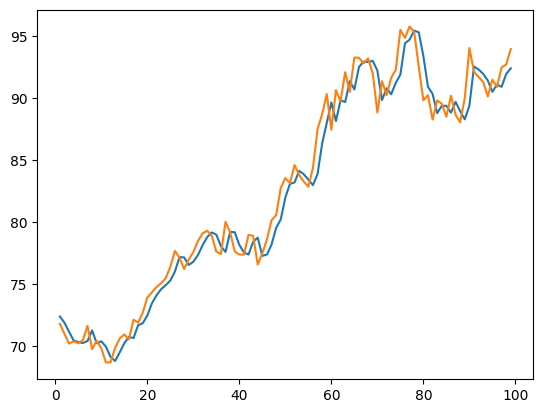

In [36]:
plt.plot(train_results['Train Predictions'][1:100])
plt.plot(train_results['Actuals'][1:100])

In [37]:
y_pred2 = model2.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, y_pred2)}')
print(f'MSE: {mean_squared_error(y_test, y_pred2)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred2))}')
print(f'R²: {r2_score(y_test, y_pred2)}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
MAE: 1.8053941590228786
MSE: 6.088745143979683
RMSE: 2.4675382760921223
R²: 0.9550500231829415


# Train Loss Val Loss

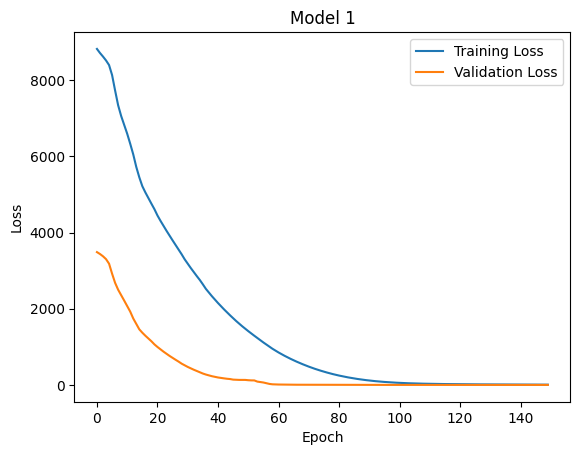

In [43]:
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.title('Model 1')
plt.ylabel('Loss')
plt.legend()
plt.show()

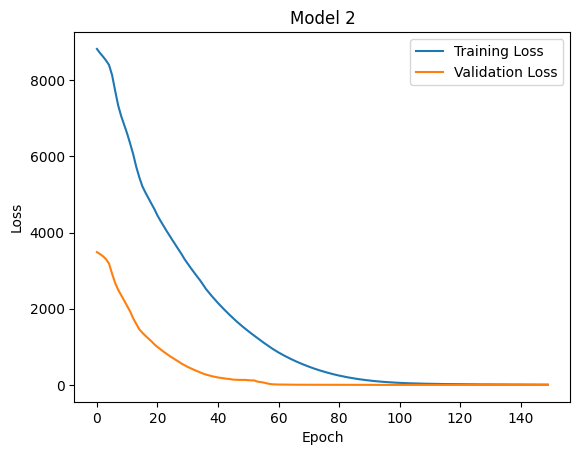

In [41]:
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.title('Model 2')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the Models

In [ ]:
model1.save('model1.h5')
model2.save('model2.h5')

# Conclusion

I think the modelf is good, from that we could see the Train Loss/Val Loss indicates the model was good fit. Therefore, from metrics, the values we got was:

1. Model 1
- **Mean Absolute Error:** 1.99
- **Mean Square Error:** 8.001
- **R-Squared:** 0.94

1. Model 2
- **Mean Absolute Error:** 1.80
- **Mean Square Error:** 6.08
- **R-Squared:** 0.95

i think from these one, i would like to recommend the **model 1**, judging from MAE, MSE and R-Squared. But From Univariates, this Multivariates was lose, judging from metrics Univariate. 

1. Univariate Model 1
- **Mean Absolute Error:** 1.62
- **Mean Square Error:** 5.49
- **R-Squared:** 0.95

2.  Univariate Model 2
- **Mean Absolute Error:** 1.80
- **Mean Square Error:** 6.08
- **R-Squared:** 0.95